# Introduction to Neural Networks

## 0) Import relevant libraries

These libraries will help us along the tutorial for basic funcionalities.

In [17]:
import requests
import numpy
import zipfile
import os
import struct
import array
import random
import matplotlib.pyplot as plt

## 1) Declare the objects

### Dataset

This class will lets us read and manipulate the MNIST dataset in order to train and validate out model.

In [18]:
class Dataset:
    def __init__(self):
        self.trainImages = None
        self.trainLabels = None
        self.trainImagesRaw = None
        self.testImagesRaw = None
        self.testImages = None
        self.testLabels = None
        self.load()

    def getTrainImages(self) -> list:
        return self.trainImages

    def getTrainLabels(self) -> list:
        return self.trainLabels

    def getTestImages(self) -> list:
        return self.testImages

    def getTestLabels(self) -> list:
        return self.testLabels

    def getSizeTrain(self) -> int:
        return len(self.trainLabels)

    def parseOutput(self, output) -> numpy.array:
        parsedOutput = [0 for i in range(10)]
        parsedOutput[output] = 1
        return numpy.array(parsedOutput)

    def unParseOutput(self, output: numpy.array) -> int:
        output = list(output)
        maxValue = max(output)
        output = output.index(maxValue)
        return output

    def getArgumentTrain(self, p: int) -> list:
        if self.trainImages is not None:
            if len(self.trainImages) > 0:
                return self.trainImages[p]
        return None

    def getArgumentTrainRaw(self, p: int) -> list:
        if self.trainImagesRaw is not None:
            if len(self.trainImagesRaw) > 0:
                return self.trainImagesRaw[p]
        return None

    def getOutputTrain(self, p: int, parsed: bool = True) -> numpy.array:
        if self.trainLabels is not None:
            if len(self.trainLabels) > 0:
                output = self.trainLabels[p]
                if not parsed:
                    return output
                return self.parseOutput(output)
        return None

    def getSizeArgumentTrain(self) -> int:
        someArgument = self.getArgumentTrain(0)
        if isinstance(someArgument, (int, float)):
            return 1
        return 0 if someArgument is None else len(someArgument)

    def getSizeOutputTrain(self) -> int:
        someOutput = self.getOutputTrain(0)
        if isinstance(someOutput, (int, float)):
            return 1
        return 0 if someOutput is None else len(someOutput)

    def getSizeTest(self) -> int:
        return len(self.testLabels)

    def getArgumentTest(self, p: int) -> list:
        if self.testImages is not None:
            if len(self.testImages) > 0:
                return self.testImages[p]
        return None

    def getArgumentTestRaw(self, p: int) -> list:
        if self.testImagesRaw is not None:
            if len(self.testImagesRaw) > 0:
                return self.testImagesRaw[p]
        return None

    def getOutputTest(self, p: int, parsed: bool = True) -> numpy.array:
        if self.testLabels is not None:
            if len(self.testLabels) > 0:
                output = self.testLabels[p]
                if not parsed:
                    return output
                return self.parseOutput(output)
        return None

    def getSizeArgumentTest(self) -> int:
        someArgument = self.getArgumentTest(0)
        if isinstance(someArgument, (int, float)):
            return 1
        return 0 if someArgument is None else len(someArgument)

    def getSizeOutputTest(self) -> int:
        someOutput = self.getOutputTest(0)
        if isinstance(someOutput, (int, float)):
            return 1
        return 0 if someOutput is None else len(someOutput)

    def load(self):
        trainImagesFilepath, trainLabelsFilepath, testImagesFilepath, testLabelsFilepath = self.downloadData()
        trainImages, trainImagesRaw, trainLabels = self.readImagesandLabels(trainImagesFilepath, trainLabelsFilepath)
        testImages, testImagesRaw, testLabels = self.readImagesandLabels(testImagesFilepath, testLabelsFilepath)
        self.trainImages = trainImages
        self.trainLabels = trainLabels
        self.trainImagesRaw = trainImagesRaw
        self.testImagesRaw = testImagesRaw
        self.testImages = testImages
        self.testLabels = testLabels
        # Cleanup files
        os.remove(trainImagesFilepath)
        os.remove(trainLabelsFilepath)
        os.remove(testImagesFilepath)
        os.remove(testLabelsFilepath)
        os.rmdir(trainImagesFilepath.split("/")[0])
        os.rmdir(trainLabelsFilepath.split("/")[0])
        os.rmdir(testImagesFilepath.split("/")[0])
        os.rmdir(testLabelsFilepath.split("/")[0])
        os.remove(trainImagesFilepath.split("/")[0].replace("-idx", ".idx"))
        os.remove(trainLabelsFilepath.split("/")[0].replace("-idx", ".idx"))
        os.remove(testImagesFilepath.split("/")[0].replace("-idx", ".idx"))
        os.remove(testLabelsFilepath.split("/")[0].replace("-idx", ".idx"))
        print(f"Dataset: Images and labels loaded succesfully!")

    def readImagesandLabels(self, imagesFilepath: str, labelsFilepath: str) -> tuple:
        # Labels
        labels = []
        with open(labelsFilepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(
                    f'Dataset - readImagesandLabels: Magic number for labels mismatch, expected 2049, got {magic}')
            labels = array.array("B", file.read())
        # Images
        with open(imagesFilepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(
                    f'Dataset - readImagesandLabels: Magic number for images mismatch, expected 2051, got {magic}')
            image_data = array.array("B", file.read())
        imagesRaw = []
        images = []
        for i in range(size):
            imagesRaw.append([0] * rows * cols)
            images.append([0] * rows * cols)
        for i in range(size):
            img = numpy.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            imagesRaw[i][:] = img
            img = img.reshape(-1)
            img = img.astype(numpy.float32) / 255.0  # Normalize inputs to go from 0 to 1 instead of 0 to 255
            images[i][:] = img
        return images, imagesRaw, labels

    @staticmethod
    def downloadData() -> tuple:
        datasetUrl = "http://tutorials.bfiapi.com/IntroductionToNeuralNetworks/MNIST_dataset.zip"
        response = requests.get(datasetUrl)
        zipFilename = datasetUrl.split("/")[-1]
        if response.status_code == 200:
            with open(zipFilename, 'wb') as f:
                f.write(response.content)
            print(f"Dataset - downloadData: File '{zipFilename}' downloaded successfully.")
        else:
            print(
                f"Dataset - downloadData: Failed to download '{zipFilename}' file. Status code: {response.status_code}")
        zip_ref = zipfile.ZipFile(zipFilename, 'r')
        zip_ref.extractall()
        zip_ref.close()
        os.remove(zipFilename)
        # This paths come directly from the data source (https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook)
        trainImagesFilepath = 'train-images-idx3-ubyte/train-images-idx3-ubyte'
        trainLabelsFilepath = 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
        testImagesFilepath = 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
        testLabelsFilepath = 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'
        return trainImagesFilepath, trainLabelsFilepath, testImagesFilepath, testLabelsFilepath

    @staticmethod
    def showImages(images, titles):
        print('\n')
        columns = 3
        rows = int(len(images) / columns) + 1
        plt.figure(figsize=(30, 20))
        index = 1
        for image, title in zip(images, titles):
            plt.subplot(rows, columns, index)
            plt.imshow(image, cmap=plt.cm.gray)
            if title != '':
                plt.title(title, fontsize=10)
            index += 1
        plt.show()


## Sigmoid

This class will help us implement the sigmoid function and it's derivative.

In [19]:
class Sigmoid:
    def __init__(self):
        pass

    @staticmethod
    def getValue(v: float):
        return 1 / (1 + numpy.exp(-v))

    @classmethod
    def getDerivative(cls, v: float):
        return cls.getValue(v) * (1 - cls.getValue(v))


### Neuron

This class will help us generalize and describe the neurons with their internal parameters and functionalities.

In [20]:
class Neuron:
    def __init__(self, value: float, delta: float, weights: list, bias: float, preactivation: float):
        self.value = value
        self.delta = delta
        self.weights = weights
        self.bias = bias
        self.preactivation = preactivation

    def setPreactivationVariable(self, inputs: list):
        self.preactivation = self.bias + numpy.dot(self.weights, inputs)

    def getActivationValue(self):
        return Sigmoid.getValue(self.preactivation)

    def setLocalGradient(self, expectedOutput: float):
        self.delta = (self.value - expectedOutput) * Sigmoid.getDerivative(self.preactivation)

    def getValue(self):
        return self.value

    def setValue(self, inputs: list):
        self.setPreactivationVariable(inputs)
        self.value = self.getActivationValue()

    def updateParameters(self, learningRatio: float, inputs):
        inputs = numpy.array(inputs, dtype=float)
        self.updateBias(learningRatio)
        self.updateWeights(learningRatio, inputs)

    def updateBias(self, learningRatio: float):
        self.bias += -learningRatio * self.delta

    def updateWeights(self, learningRatio: float, inputs):
        self.weights += -learningRatio * self.delta * inputs

    def updateLocalGradient(self, nextLayer, neuronIndex: int):
        nextLayerWeights = []
        nextLayerDeltas = []
        for nextLayerNeuron in nextLayer.neurons:
            nextLayerWeights.append(nextLayerNeuron.weights[neuronIndex])
            nextLayerDeltas.append(nextLayerNeuron.delta)
        nextLayerWeights = numpy.array(nextLayerWeights, dtype=float)
        nextLayerDeltas = numpy.array(nextLayerDeltas, dtype=float)
        self.delta = Sigmoid.getDerivative(self.preactivation) * numpy.dot(nextLayerWeights, nextLayerDeltas)

    @classmethod
    def create(cls, numberWeights: int):
        value = 0
        delta = 0
        # Initializes a normally random vector the size of the neuron
        weights = numpy.random.normal(loc=0.0, scale=0.1, size=numberWeights)
        bias = 0
        preactivation = 0
        return cls(value, delta, weights, bias, preactivation)


### Layer

This class will help us manage a group of neurons, their relationships and calculations.

In [21]:
class Layer:
    def __init__(self):
        self.neurons = []
        self.value = None
        self.lastInputs = None

    def insertNeuron(self, neuron: Neuron):
        self.neurons.append(neuron)

    def getSize(self):
        return len(self.neurons)

    def setValue(self, input: numpy.array):
        self.value = input

    def getValue(self):
        return self.value

    def forwardPropagate(self, previousLayer):
        inputs = numpy.array(previousLayer.getValue(), dtype=float)
        self.lastInputs = inputs
        outputs = []
        for neuron in self.neurons:
            neuron.setValue(inputs)
            outputs.append(neuron.value)
        self.setValue(numpy.array(outputs, dtype=float))
        return self

    def setLocalGradient(self, expectedOutput: list):
        for i, neuron in enumerate(self.neurons):
            neuron.setLocalGradient(expectedOutput[i])

    def backPropagate(self, nextLayer, learningRatio: float):
        if nextLayer is not None and nextLayer.getSize() > 0:
            for neuronIndex, neuron in enumerate(self.neurons):
                neuron.updateLocalGradient(nextLayer, neuronIndex)
        inputs = self.lastInputs
        if inputs is None:
            return
        for neuron in self.neurons:
            neuron.updateParameters(learningRatio, inputs)

    @classmethod
    def create(cls, numberNeurons: int):
        layer = cls()
        for i in range(numberNeurons):
            neuron = Neuron.create(0)
            layer.insertNeuron(neuron)
        return layer

    def createNextLayer(self, numberNeurons: int):
        newLayer = Layer()
        numberOfWeights = self.getSize()
        for i in range(numberNeurons):
            neuron = Neuron.create(numberOfWeights)
            newLayer.insertNeuron(neuron)
        return newLayer


### Network

This class will allow us to manipulate layers of neurons as one and implement the interactions needed for training the model.

In [22]:
class Network:
    def __init__(self, learningRatio: float):
        self.learningRatio = learningRatio
        self.layers = []

    def loss(self, output: list, expected: list):
        output = numpy.array(output)
        expected = numpy.array(expected)
        return numpy.mean((output - expected) ** 2)  # This is the mean square's error loss function

    def insertLayer(self, layer: Layer):
        self.layers.append(layer)

    def forwardPropagate(self, input: list) -> list:
        previousLayer = self.layers[0]
        previousLayer.setValue(numpy.array(input, dtype=float))
        for layer in self.layers[1:]:
            layer.forwardPropagate(previousLayer)
            previousLayer = layer
        return self.layers[-1].getValue()

    def backPropagate(self, expectedOutput: list):
        # Iterate from output layer down to first hidden layer (stop before input layer index 0)
        for i in range(len(self.layers) - 1, 0, -1):
            layer = self.layers[i]
            # The nextLayer is in forward direction (None for output case)
            nextLayer = self.layers[i + 1] if (i + 1) < len(self.layers) else None
            # Output layer delta computed from target
            if i == len(self.layers) - 1:
                layer.setLocalGradient(numpy.array(expectedOutput, dtype=float))
            # Compute deltas for this layer using nextLayer's weights/deltas
            layer.backPropagate(nextLayer, self.learningRatio)

    def train(self, dataset, epochs: int):
        print(f"Training network for {epochs} epochs!")
        # Training
        for epoch in range(epochs):
            outputsValues = []
            expectedValues = []
            for i in range(dataset.getSizeTrain()):
                input = dataset.getArgumentTrain(i)
                expected = dataset.getOutputTrain(i)
                outputs = self.forwardPropagate(input)
                outputsValues.append(numpy.array(outputs))
                expectedValues.append(numpy.array(expected))
                self.backPropagate(expected)
            print(f"Epoch {epoch} error (MSE): {self.loss(outputsValues, expectedValues):.6f}")
        # Training error
        outputsValues = []
        expectedValues = []
        for i in range(dataset.getSizeTrain()):
            input = dataset.getArgumentTrain(i)
            expected = dataset.getOutputTrain(i)
            outputs = self.forwardPropagate(input)
            outputsValues.append(numpy.array(outputs))
            expectedValues.append(numpy.array(expected))
        print(f"Training finished, error (MSE): {self.loss(outputsValues, expectedValues):.6f}")

    def validate(self, dataset):
        # General
        print(f"Validating network!")
        outputsValues = []
        expectedValues = []
        for i in range(dataset.getSizeTest()):
            input = dataset.getArgumentTest(i)
            expected = dataset.getOutputTest(i)
            outputs = self.forwardPropagate(input)
            outputsValues.append(numpy.array(outputs))
            expectedValues.append(numpy.array(expected))
        print(f"Validation error (MSE): {self.loss(outputsValues, expectedValues):.6f}")
        # Some random particular cases
        images = []
        titles = []
        for i in range(0, 9):
            randomIndex = random.randint(1, 10000)
            randomInputRaw = dataset.getArgumentTestRaw(randomIndex)
            randomInput = dataset.getArgumentTest(randomIndex)
            outputs = self.forwardPropagate(randomInput)
            prediction = dataset.unParseOutput(outputs)
            randomOutputRaw = dataset.getOutputTest(randomIndex, parsed=False)
            images.append(randomInputRaw)
            titleText = f'Validation image [{str(randomIndex)}] = Value: {str(randomOutputRaw)} / Prediction: {str(prediction)}'
            print(titleText)
            titles.append(titleText)
        dataset.showImages(images, titles)

    @classmethod
    def create(cls, dataset):
        # Create the layers
        inputLayer = Layer.create(dataset.getSizeArgumentTrain())
        hiddenLayer1 = inputLayer.createNextLayer(16)
        hiddenLayer2 = hiddenLayer1.createNextLayer(10)
        output = hiddenLayer2.createNextLayer(10)
        # Construct neural network
        neuralNetwork = cls(0.1)
        neuralNetwork.insertLayer(inputLayer)
        neuralNetwork.insertLayer(hiddenLayer1)
        neuralNetwork.insertLayer(hiddenLayer2)
        neuralNetwork.insertLayer(output)
        return neuralNetwork


## 2) Create the dataset and neural network

When creating the Dataset object, we load all the training an validating data, also when creating the neural network we use the dataset size for the network arquitecture.

In [23]:
dataset = Dataset()
neuralNetwork = Network.create(dataset)

Dataset - downloadData: File 'MNIST_dataset.zip' downloaded successfully.
Dataset: Images and labels loaded succesfully!


## 3) Train neural network

For training we will backpropagate all the training data 5 times (epochs). This way we will see improvements in the error between inputs and outputs.

In [24]:
epochs = 5
neuralNetwork.train(dataset, epochs)

Training network for 5 epochs!
Epoch 0 error (MSE): 0.053108
Epoch 1 error (MSE): 0.015889
Epoch 2 error (MSE): 0.012771
Epoch 3 error (MSE): 0.011447
Epoch 4 error (MSE): 0.010594
Training finished, error (MSE): 0.010473


## 4) Validate neural network

For validation we give the network the validation data inputs and calculate the error with the actual labels for this data, that the network has never seen.

Also we test 9 random inputs and outputs, showing the input as an image, the output or label and the network prediction for this data.

Validating network!
Validation error (MSE): 0.011497
Validation image [1405] = Value: 5 / Predicition: 5
Validation image [8903] = Value: 3 / Predicition: 3
Validation image [1275] = Value: 4 / Predicition: 4
Validation image [6038] = Value: 6 / Predicition: 6
Validation image [8278] = Value: 0 / Predicition: 4
Validation image [2512] = Value: 8 / Predicition: 8
Validation image [4226] = Value: 5 / Predicition: 5
Validation image [2565] = Value: 7 / Predicition: 7
Validation image [9029] = Value: 6 / Predicition: 6




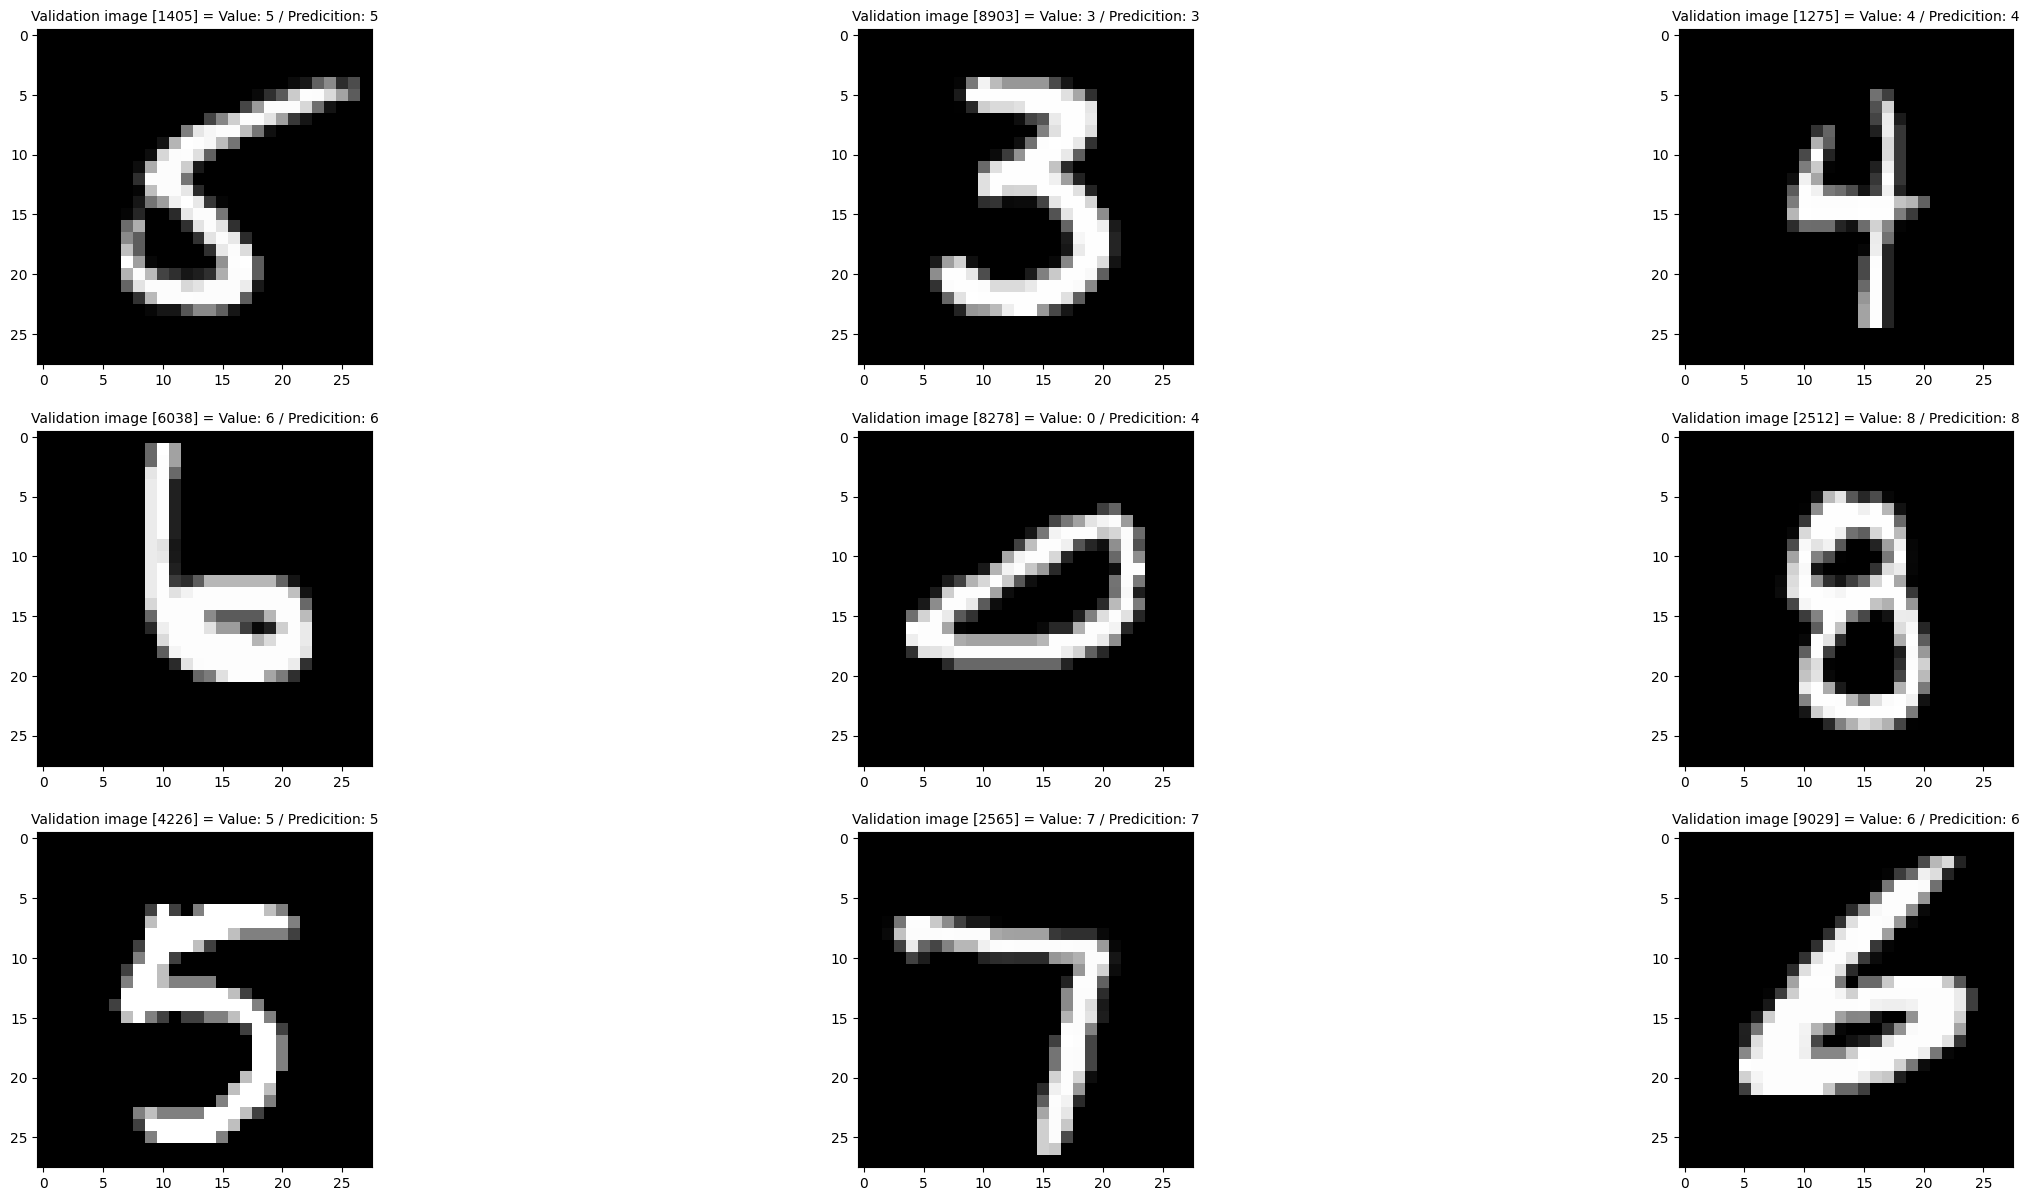

In [25]:
neuralNetwork.validate(dataset)